## testing for pyarmfinder

In [1]:
import sys,os,subprocess,glob
import pandas as pd
pd.set_option('display.max_columns', 14)
pd.set_option('display.width', 200)
import numpy as np
import pylab as plt
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
import urllib.request
sys.path.append('../')
from pyamrfinder import tools, app
datadir = '../pyamrfinder/data/'
dbdir = app.dbdir

In [8]:
def fetch_sequence_db(name='card'):
    """get sequences"""
    
    path = dbdir
    if not os.path.exists(path):
        os.makedirs(path)
    links = {'card':'https://github.com/tseemann/abricate/raw/master/db/card/sequences',
            'resfinder':'https://raw.githubusercontent.com/tseemann/abricate/master/db/resfinder/sequences',
            'vfdb':'https://raw.githubusercontent.com/tseemann/abricate/master/db/vfdb/sequences'
            }
    if name in links:
        url = links[name]
    else:
        print('no such name')
        return
        
    filename = os.path.join(path,"%s.fa" %name)
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
    return

fetch_sequence_db('resfinder')

In [ ]:
fname='/local/abricate/db/card/sequences'
f=open(fname,'r')
for i in f.readlines():

sp=SeqIO.parse(handle=f,format='fasta')
seqs=[]
print (seqs)

In [9]:
def make_blast_database(filenames):
    """Make blast dbs of multiple input files"""

    rec=[]
    for n in filenames:
        seqs = list(SeqIO.parse(n,'fasta'))
        for s in seqs:
            s.id = n + '~' + s.id
        rec.extend(seqs)
    #ref = list(SeqIO.parse('genomes/ecoli_k12.fa','fasta'))
    #ref[0].id = 'ecoli_k12~1'
    #rec.extend(ref)
    SeqIO.write(rec, 'targets.fasta', 'fasta')
    cmd = 'makeblastdb -dbtype nucl -in targets.fasta'
    subprocess.check_output(cmd, shell=True)
    return

make_blast_database(['../test_files/RF15B.fa','../test_files/RF15A.fa'])

In [10]:
def find_genes(target, ref='card', ident=90, coverage=75):
    """Find ref genes by blasting the target sequences"""

    path = os.path.join(dbdir,'%s.fa' %ref)
    dbseqs = list(SeqIO.parse(path,'fasta'))
    print ('blasting %s sequences' %len(dbseqs))
    bl = tools.blast_sequences(target, dbseqs, maxseqs=100, evalue=.1,
                               cmd='blastn', show_cmd=True)
    
    bl['qlength'] = bl.sequence.str.len()
    bl['coverage'] = bl.length/bl.qlength*100
    bl = bl[bl.coverage>coverage]
    bl = bl[bl.pident>ident]
    bl['filename'] = bl.sseqid.apply(lambda x: x.split('~')[0],1)
    bl['id'] = bl.filename.apply(lambda x: os.path.basename(x),1)
    bl['contig'] = bl.sseqid.apply(lambda x: x.split('~')[1],1)
    bl['gene'] = bl['qseqid'].apply(lambda x: x.split('~~~')[1],1)
    
    bl = bl.sort_values('coverage', ascending=False).drop_duplicates(['sstart','send'])
    #print (bl)
    cols = ['qseqid','pident','sstart','send','coverage','contig','gene','id','filename']
    bl = bl[cols]
    return bl

bl = find_genes('targets.fasta', 'resfinder')

blasting 3077 sequences
blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db targets.fasta -evalue 0.1 -max_target_seqs 100 -num_threads 2


In [ ]:
#bl.sort_values('coverage', ascending=False).drop_duplicates(['sstart','send'])
bl["group_diff"] = bl.sort_values(by=["sstart"])\
                     .groupby("gene")["sstart"]\
                     .diff()\
                     .gt(5)\
                     .cumsum()

print (bl)
g = bl.groupby(["group_diff"])
g.groups

In [11]:
def get_gene_hits(res, gene, filename, db='card'):
    """Get blast hit results"""

    path = os.path.join(dbdir,'%s.fa' %db)
    #dbseqs = SeqIO.to_dict(SeqIO.parse(path,'fasta'))
    dbseqs = tools.fasta_to_dataframe(path)
    dbseqs['gene'] = dbseqs.description.apply(lambda x: x.split('~~~')[1],1)
    #print (dbseqs)
    x = res[res.gene==gene]
   
    found=[]
    contigs = []
    for i,r in x.iterrows():
        name = r.id
        print (name)
        #if name not in isolates: continue
        seqs = SeqIO.to_dict(SeqIO.parse(r.filename,'fasta'))
        node = r.contig
        if r.sstart<r.send:
            s = seqs[node].seq[r.sstart:r.send]
        else:
            s = seqs[node].seq[r.send:r.sstart].reverse_complement()

        s = SeqRecord(id=name,seq=s)
        found.append(s)
        print (name, r.gene, r['coverage'], r['pident'], len(s), node)
        #add card seq
        contigs.append(seqs[node])

    row = dbseqs[dbseqs.gene==gene].iloc[0]
    print (row)
    found.append(SeqRecord(id=row['name'],seq=Seq(row.sequence)))
    seqfile = 'temp.fa'
    SeqIO.write(found, seqfile,'fasta')
    SeqIO.write(contigs,'contigs.fa','fasta')
    #maaft_alignment(seqfile)
    aln = tools.clustal_alignment(seqfile)
    tools.show_alignment(aln)
    #print (aln)
    return


In [ ]:
get_gene_hits(bl, 'dfrA1_9', '../test_files/RF15B.fa', 'resfinder')

In [12]:
def pivot_blast_results(bl):
    x = bl.drop_duplicates(['sstart'])
    m = pd.pivot_table(x, index='id', columns='gene', values='pident')#, aggfunc=np.size)   
    #m = m[m.columns[m.loc['ecoli_k12'].isnull()]]   
    #m = m.drop('ecoli_k12')
    return m

m = pivot_blast_results(bl)
m

gene,aac(3)-IVa_1,aadA1_2,aadA23_1,aadA24_1,aadA3_1,ant(3'')-Ia_1,aph(3'')-Ib_2,...,aph(3'')-Ib_4,aph(4)-Ia_1,aph(6)-Id_4,aph(6)-Id_5,dfrA1_11,dfrA1_12,dfrA1_17
id,,,,,,,,,,,,,,,
RF15A.fa,NaN,NaN,97.28,93.059,90.53,99.377,100.0,...,99.876,NaN,99.88,99.881,NaN,99.789,99.577
RF15B.fa,99.843,96.97,97.28,93.059,NaN,99.377,100.0,...,NaN,100.0,99.88,99.881,99.156,NaN,99.577


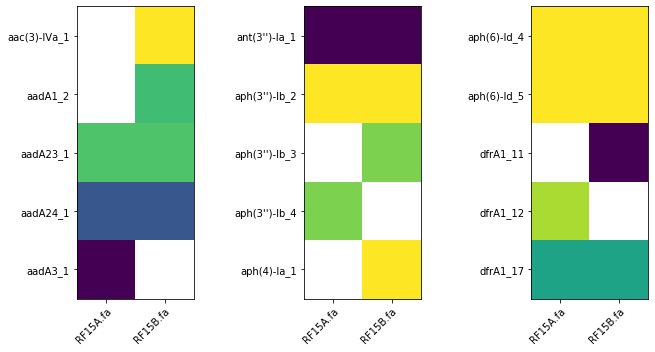

In [30]:
def merge_info(x):
    m=info[['id','stage']]
    x=m.merge(x,right_index=True,left_on='id')
    x=x.set_index(['stage','id'])
    return x

def plot_heatmap(m, fig=None):

    from matplotlib.gridspec import GridSpec
    l=3    
    if fig == None:
        fig = plt.figure()
    else:
        fig.clear()
    gs = fig.add_gridspec(1, l)
    chunks = np.array_split(m,l)
    i=0
    for df in chunks:
        ax = fig.add_subplot(gs[0,i])      
        im = ax.imshow(df)
        ax.set_xticks(np.arange(len(df.T)))
        ax.set_yticks(np.arange(len(df)))
        ax.set_xticklabels(df.columns)
        ax.set_yticklabels(df.index)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")        
        i+=1
    plt.tight_layout()
    return 

fig = plt.figure(figsize=(10,5))
plot_heatmap(m.T, fig=fig)

blasting 2617 sequences
blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db targets.fasta -evalue 0.1 -max_target_seqs 100 -num_threads 2
gene      AAC(3)-IV  ANT(3'')-IIa  APH(3'')-Ib  APH(4)-Ia  APH(6)-Id     CRP  CTX-M-107  ...    mdtO    mdtP    msbA    pmrF   sul2   tolC    yojI
id                                                                                       ...                                                      
RF14A.fa        NaN           NaN          NaN        NaN        NaN  99.684     99.652  ...  97.076  97.273  98.685  98.246  100.0  98.32  97.749
RF15A.fa        NaN        99.377       99.876        NaN     99.881     NaN        NaN  ...     NaN     NaN     NaN     NaN    NaN    NaN     NaN
RF15B.fa      100.0        99.377       99.876      100.0     99.881     NaN        NaN  ...     NaN     NaN     NaN     NaN    NaN    NaN     NaN

[3 row

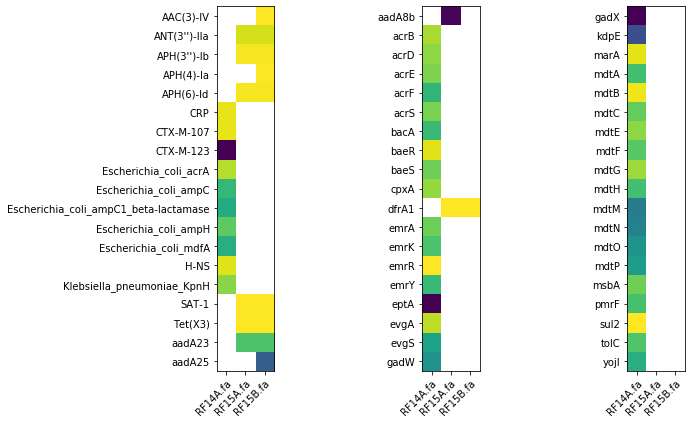

In [16]:
# run in sequence

def run(filenames, db='card'):
    """Run pipeline"""
    
    fetch_sequence_db(db)
    make_blast_database(filenames)
    bl = find_genes('targets.fasta', db)
    #find_gene_hits(bl, 'dfrA1_9', '../test_files/RF15B.fa', db)
    bl.to_csv('%s_results.csv' %db)
    m = pivot_blast_results(bl)
    print (m)
    plot_heatmap(m.T)
    m.to_csv('%s_matrix.csv' %db)
    return

inpath = '../test_files/'
filenames = glob.glob(os.path.join(inpath,'*.fa*'))
#run(filenames, db='resfinder')
run(filenames, db='card')

In [190]:
def abricate(filename, db='card',id=None):
    
    cmd = '/local/abricate/bin/abricate %s -db %s --mincov 50 --minid 90 > temp.tab' %(filename,db)
    print (cmd)
    subprocess.check_output(cmd, shell=True, executable='/bin/bash')
    df = pd.read_csv('temp.tab',sep='\t')
    id = os.path.basename(filename)
    df['id'] = id
    return df

x = abricate('../test_files/RF15A.fa')

/local/abricate/bin/abricate ../test_files/RF15A.fa -db card --mincov 50 --minid 90 > temp.tab


In [191]:
make_blast_database(['../test_files/RF15A.fa'])
y = find_genes('targets.fasta', 'card', coverage=50)

blasting 2617 sequences
blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db targets.fasta -evalue 0.1 -max_target_seqs 100 -num_threads 2


In [192]:
print (x.GENE)
print (y.gene)

0    APH(3'')-Ib
1      APH(6)-Id
2          SAT-1
3           aadA
Name: GENE, dtype: object
17          aadA21
3      APH(3'')-Ib
27           dfrA1
9          Tet(X3)
8            SAT-1
7        APH(6)-Id
15          aadA17
19          aadA23
2     ANT(3'')-IIa
Name: gene, dtype: object
